In [864]:
#=============================================================================
# class Cell
# usage: scr = Screen('Neurons',4,10)
#        cell = Cell(nr.at(1,2),k,g,K,P)
#        cell.show()
#=============================================================================

from carabao.screen import Screen
import torch
import numpy

class Cell:
    def __init__(self,screen=None,k=None,g=None,K=None,P=None):
        self.at(screen)
        self.config(k,g,K,P)
        self.x = 0
        self.y = float('nan')
        self.u = float('nan')
        self.b = float('nan')   # burst signal
        self.p = float('nan')   # post synaptic effect
        self.l = float('nan')
        self.c = float('nan')
        self.q = float('nan') 
        self.x_ = float('nan')
        self.y_ = float('nan')
        self.verbose = 0    # verbose mode disabled
        self.iteration = None
        
    def config(self,k,g,K,P):
        nan = float('nan')
        self.eta = 0.5      # synaptic threshold
        self.theta = 2      # dendritic threshold
        self.pdelta = 0.04  # positive learning delata
        self.ndelta = 0.02  # negative learning delta
        self.k = k;
        self.g = g;  
        self.K = K;
        self.P = P;
        self.Q = P*nan
        self.L = P*nan        # boolean learning matrix
        self.D = P*nan        # permanence learning delta
        self.W = P*nan
        self.Z = P*nan
    
    def place(self,screen,ij):
        self.screen = screen
        self.ij = ij

    def at(self,screen):
        if screen != None:
            self.place(screen,screen.ij)

    def select(self,c,K):
        self.Z = 0*K
        for mu in range(0,K.size(0)):
            for nu in range(0,K.size(1)):
                self.Z[mu,nu] = c[K[mu,nu]];
        return self.Z

    def norm(self,M):    # max of column sums
        result = 0
        for j in range(0,M.size(0)):
            sumj = M[j].sum().item()
            result = result if sumj < result else sumj
        return result
            
    def iterate(self):    # update iteration count
        if self.iteration == None:
            self.iteration = 0
        else:
            self.iteration += 1

    def burst(self,c):
        self.q = []
        for k in range(0,len(self.g)):
           qk = c[self.g[k]]
           self.q.append(qk)
        b = (sum(self.q) == 0)               # burst signal
        return int(b)

    def learn(self,Q):                       # learning vector
        d,s = Q.size()
        l = [];  p = []
        for mu in range(0,d):
            norm = sum(Q[mu]).item()
            l.append(norm)
            p.append(int(norm >= self.theta))
        L = torch.tensor([p]).t()*torch.ones(1,Q.size(1))
        return l,L,p

    def input(self,u,c=None):                # update input
        self.nanify('b,p,L,D,W,Z,Q')
        self.u = u
        self.y_ = self.y
        self.y = self.u * self.x
        if c != None:
            c[self.k] = self.y
            self.c = c
        self.iterate()        
        if self.verbose > 0:
            self.log("(input)")
        return c
        
    def context(self,c):                    # update context
        self.c = c
        self.b = self.burst(c)
        self.y = self.y if self.b ==  0 else 1
        self.W = (self.P >= self.eta)
        self.Z = self.select(c,self.K)
        self.Q = torch.mul(self.Z,self.W)   # synapitcs matrix
        self.l,self.L,self.p = self.learn(self.Q)
        self.D = self.y*(self.L*self.Q*self.pdelta-self.L*self.ndelta)
        self.x1 = self.u * max(self.p)
        self.y_ = self.y                    # y is now steady
        if self.verbose > 0:
            self.log("(context)")
        return c

    def transition(self,c):                 # state transition
        self.x_ = self.x
        self.x = self.x1
        self.x1 = float('nan')
        c[self.k] = self.y
        self.P += self.D                    # learning
        self.c = c
        if self.verbose > 0:
            self.log("(transition)")
        return c

    def nanify(self,tag):           # set some items equal to nan
        nan = float('nan');
        if tag == 'b,p,L,D,W,Z,Q':
            self.b = nan            # at this phase no burst signal needed
            self.p = nan            # at this phase no post s. effect needed
            self.W = self.W*nan     # no weights needed
            self.Z = self.Z*nan     # no pre-synaptic signals needed
            self.L = self.L*nan     # no binary learning matrix
            self.D = self.D*nan     # no learning deltas

    def valid(self,arg):            # check if arg has valid numbers
        isnan = numpy.isnan(arg).any()
        return isnan == False
        
    def clone(self,screen):
        self.screen = screen
        return self

    def plot(self,i=None,j=None):
        if i != None:
            self.place(self.screen,(i,j))
        self.screen.cell(self.ij,self.x,self.y,self.P,self.Q)
        self.screen.input(self.ij[1],self.u)
        self.screen.show

    def show(self,i=None,j=None):
        if i != None:
            self.plot(i,j)
        can = self.neurons.canvas()
        self.plot()

    def print(self,tag,msg,arg):   # .print("matrix","Q:",Q)
        if tag == 'matrix':
            m,n = arg.size()
            print(msg,"[",end='')
            sepi = ''
            for i in range(0,m):
                print(sepi,end='');  sepi = '; ';  sepj = ''
                for j in range(0,n):
                    s = "%4g" % arg[i,j].item()
                    s = s if s[0:2] != '0.' else s[1:]
                    s = s if s[0:3] != '-0.' else '-'+s[2:]
                    print("%5s" % s, end=''); 
                    sepj = ' '
            print(']')
        elif tag == 'number':
            print(msg,"%4g" % arg)
        
    def log(self,msg=None):
        nan = float('nan')
        msg = msg if msg != None else ""
        print("-------------------------------------------------------------")
        print("iteration: ",self.iteration,msg)
        print("   k:",self.k,", g:",self.g,", eta:",self.eta)
        self.print('matrix',"   K:",self.K)
        self.print('matrix',"   P:",self.P)
        if self.valid(self.W):
            self.print('matrix',"   W:",self.W)
        if self.valid(self.Z):
            self.print('matrix',"   Z:",self.Z)
        if self.valid(self.Q):
            self.print('matrix',"   Q:",self.Q)
        if self.valid(self.L):
            self.print('matrix',"   L:",self.L)
        if self.valid(self.D):
            self.print('matrix',"   D:",self.D)
        if self.valid(self.b):
            print("   b:",self.b,", q:",self.q,
              " (||q||=%g)" % (nan if numpy.isnan(self.q).any() else sum(self.q)))
        if self.valid(self.l):
            print("   l:",self.l,", p:",self.p,
              "(||Q||=max(l)=%g, theta:%g)" % (self.norm(self.Q),self.theta))
        print("   u:",self.u)
        print("   x: %g (was: %g)" % (self.x,self.x_))
        print("   y: %g (was: %g)" % (self.y,self.y_))
        print("   c:",self.c)
        print("-------------------------------------------------------------")
        


g: [0, 1, 2, 3]
K: [    1    3    5    7    9;     3    4    5    6    7]
P: [  .12  .32  .54  .77    0;     0  .61  .45    0    0]


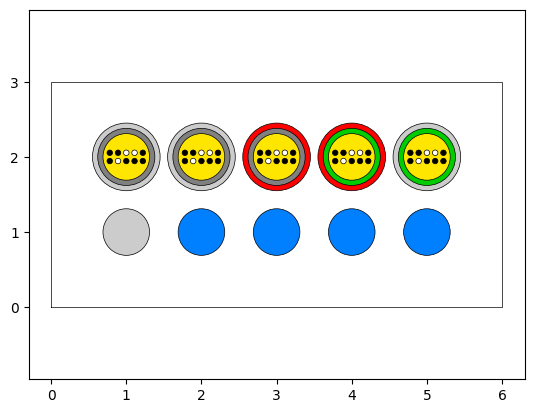

In [865]:
# Setup a cell

g = [0,1,2,3]                # group indices
print("g:",g)

K = torch.tensor([[1,3,5,7,9],[3,4,5,6,7]])
cell.print('matrix',"K:",K)

P = torch.tensor([[0.12,0.32,0.54,0.77,0],[0,0.61,0.45,0,0]])
cell.print('matrix',"P:",P)

    # create an inactive neuron

scr = Screen('Neurons',1,5)
cell = Cell(scr,0,g,K,P)
cell.plot()

    # cell excitation

cell.u = 1
cell.plot(0,1)

    # cell activation

cell.y = 1
cell.plot(0,2)

    # predictive state activation

cell.x = 1
cell.plot(0,3)

    # cell deactivation

cell.y = 0
cell.plot(0,4)




-------------------------------------------------------------
iteration:  None 
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  .12  .32  .54  .77    0;     0  .61  .45    0    0]
   u: nan
   x: 0 (was: nan)
   y: nan (was: nan)
   c: nan
-------------------------------------------------------------


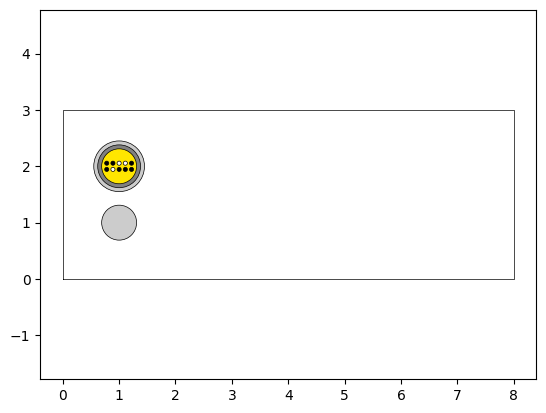

In [866]:
# step 1: create an inactive neuron

c = [0,0,0,0,1,1,1,1,0,1]    # context
scr = Screen('Neurons',1,7)
cell = Cell(scr,0,g,K,P)
cell.verbose = 1
cell.log()
cell.plot()

-------------------------------------------------------------
iteration:  0 (input)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  .12  .32  .54  .77    0;     0  .61  .45    0    0]
   u: 1
   x: 0 (was: nan)
   y: 0 (was: nan)
   c: [0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
-------------------------------------------------------------


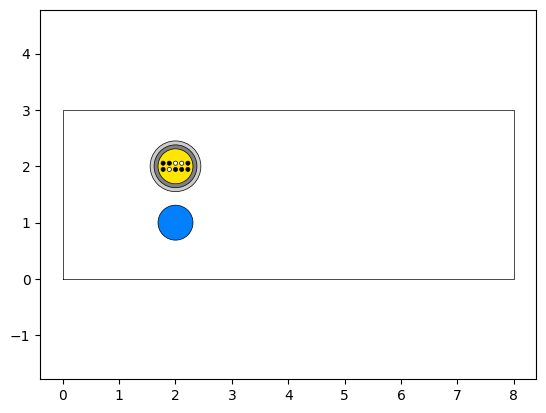

In [867]:
# step 2 / iteration 0: apply input u(0) to neuron

cell.screen = Screen('Neurons',1,7)
c = cell.input(1,c)
cell.plot(0,1)

-------------------------------------------------------------
iteration:  0 (context)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  .12  .32  .54  .77    0;     0  .61  .45    0    0]
   W: [    0    0    1    1    0;     0    1    0    0    0]
   Z: [    0    0    1    1    1;     0    1    1    1    1]
   Q: [    0    0    1    1    0;     0    1    0    0    0]
   L: [    1    1    1    1    1;     0    0    0    0    0]
   D: [ -.02 -.02  .02  .02 -.02;     0    0    0    0    0]
   b: 1 , q: [0, 0, 0, 0]  (||q||=0)
   l: [2, 1] , p: [1, 0] (||Q||=max(l)=2, theta:2)
   u: 1
   x: 0 (was: nan)
   y: 1 (was: 1)
   c: [0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
-------------------------------------------------------------


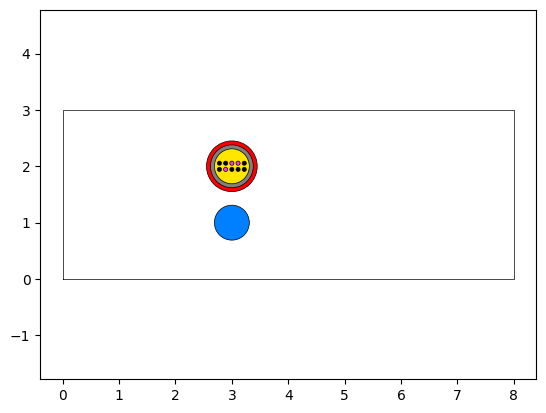

In [868]:
# step 3 / iteration 0: apply context c(0) to neuron

cell.screen = Screen('Neurons',1,7)
c = cell.context(c)
cell.plot(0,2)

-------------------------------------------------------------
iteration:  0 (transition)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  0.1  0.3  .56  .79 -.02;     0  .61  .45    0    0]
   W: [    0    0    1    1    0;     0    1    0    0    0]
   Z: [    0    0    1    1    1;     0    1    1    1    1]
   Q: [    0    0    1    1    0;     0    1    0    0    0]
   L: [    1    1    1    1    1;     0    0    0    0    0]
   D: [ -.02 -.02  .02  .02 -.02;     0    0    0    0    0]
   b: 1 , q: [0, 0, 0, 0]  (||q||=0)
   l: [2, 1] , p: [1, 0] (||Q||=max(l)=2, theta:2)
   u: 1
   x: 1 (was: 0)
   y: 1 (was: 1)
   c: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
-------------------------------------------------------------


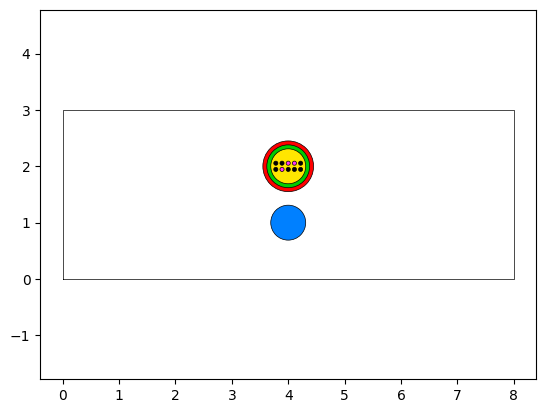

In [869]:
# step 4 / iteration 0: perform state transition

cell.screen = Screen('Neurons',1,7)
c = cell.transition(c)
cell.plot(0,3)

-------------------------------------------------------------
iteration:  1 (input)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  0.1  0.3  .56  .79 -.02;     0  .61  .45    0    0]
   Q: [    0    0    1    1    0;     0    1    0    0    0]
   l: [2, 1] , p: nan (||Q||=max(l)=2, theta:2)
   u: 1
   x: 1 (was: 0)
   y: 1 (was: 1)
   c: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
-------------------------------------------------------------


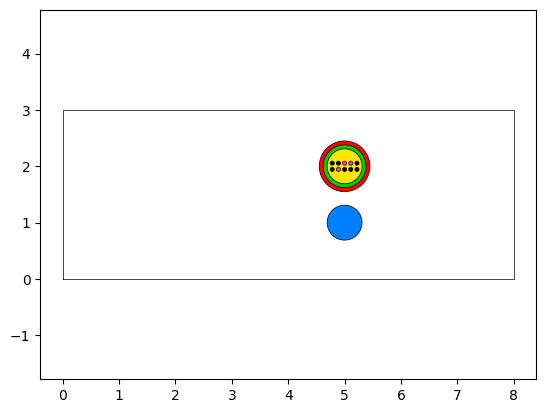

In [870]:
# step 5 / iteration 1: apply input u(0) to neuron

cell.screen = Screen('Neurons',1,7)
c = cell.input(1,c)
cell.plot(0,4)

-------------------------------------------------------------
iteration:  1 (context)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  0.1  0.3  .56  .79 -.02;     0  .61  .45    0    0]
   W: [    0    0    1    1    0;     0    1    0    0    0]
   Z: [    0    0    1    1    1;     0    1    1    1    1]
   Q: [    0    0    1    1    0;     0    1    0    0    0]
   L: [    1    1    1    1    1;     0    0    0    0    0]
   D: [ -.02 -.02  .02  .02 -.02;     0    0    0    0    0]
   b: 0 , q: [1, 0, 0, 0]  (||q||=1)
   l: [2, 1] , p: [1, 0] (||Q||=max(l)=2, theta:2)
   u: 1
   x: 1 (was: 0)
   y: 1 (was: 1)
   c: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
-------------------------------------------------------------


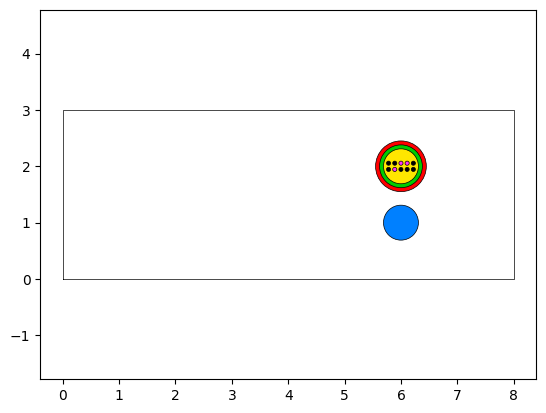

In [871]:
# step 6 / iteration 1: apply context c(0) to neuron

cell.screen = Screen('Neurons',1,7)
cell.context(c)
cell.plot(0,5)

-------------------------------------------------------------
iteration:  1 (transition)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  .08  .28  .58  .81 -.04;     0  .61  .45    0    0]
   W: [    0    0    1    1    0;     0    1    0    0    0]
   Z: [    0    0    1    1    1;     0    1    1    1    1]
   Q: [    0    0    1    1    0;     0    1    0    0    0]
   L: [    1    1    1    1    1;     0    0    0    0    0]
   D: [ -.02 -.02  .02  .02 -.02;     0    0    0    0    0]
   b: 0 , q: [1, 0, 0, 0]  (||q||=1)
   l: [2, 1] , p: [1, 0] (||Q||=max(l)=2, theta:2)
   u: 1
   x: 1 (was: 1)
   y: 1 (was: 1)
   c: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
-------------------------------------------------------------


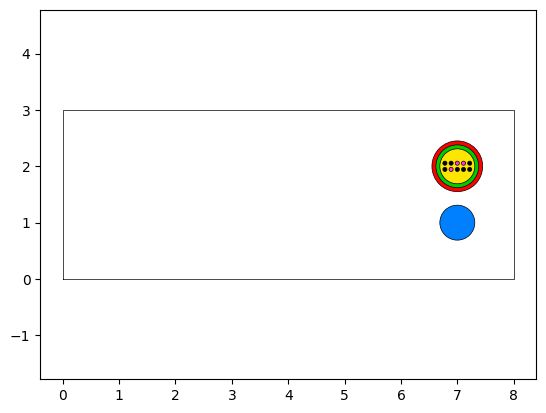

In [872]:
# step 7 / iteration 1: perform state transition

cell.screen = Screen('Neurons',1,7)
c = cell.transition(c)
cell.plot(0,6)

-------------------------------------------------------------
iteration:  0 (input)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  .08  .28  .58  .81 -.04;     0  .61  .45    0    0]
   u: 1
   x: 0 (was: nan)
   y: 0 (was: nan)
   c: [0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
-------------------------------------------------------------
-------------------------------------------------------------
iteration:  0 (context)
   k: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K: [    1    3    5    7    9;     3    4    5    6    7]
   P: [  .08  .28  .58  .81 -.04;     0  .61  .45    0    0]
   W: [    0    0    1    1    0;     0    1    0    0    0]
   Z: [    0    0    1    1    1;     0    1    1    1    1]
   Q: [    0    0    1    1    0;     0    1    0    0    0]
   L: [    1    1    1    1    1;     0    0    0    0    0]
   D: [ -.02 -.02  .02  .02 -.02;     0    0    0    0    0]
   b: 1 , q: [0, 0, 0, 0]  (||q||=0)
   l: [2, 1] , p: [1, 0] 

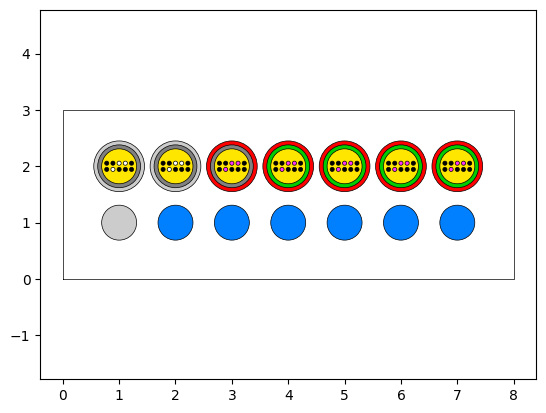

In [873]:
# all together now

    # step 1: create an inactive neuron

scr = Screen('Neurons',1,7)
c = [0,0,0,0,1,1,1,1,0,1]    # context

cell = Cell(scr,0,g,K,P)
cell.verbose = 1
cell.plot()

    # step 2 / iteration 0: apply input u(0) to neuron

c = cell.input(1,c)
cell.plot(0,1)

    # step 3 / iteration 0: apply context c(0) to neuron

c = cell.context(c)
cell.plot(0,2)

    # step 4 / iteration 0: perform state transition

c = cell.transition(c)
cell.plot(0,3)

    # step 5 / iteration 1: apply input u(0) to neuron

c = cell.input(1,c)
cell.plot(0,4)

    # step 6 / iteration 1: apply context c(0) to neuron

cell.context(c)
cell.plot(0,5)

    # step 7 / iteration 1: perform state transition

c = cell.transition(c)
cell.plot(0,6)



In [874]:
T=torch.tensor([cell.p]).t()*torch.ones(1,5)
T

tensor([[1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0.]])